In [1]:
# import gdown
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# import os
import pandas as pd

import pyro
import pyro.distributions as pdist
import scanpy as sc
import seaborn as sns

# import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log

from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
from pyro.optim import Adam

import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler

# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmTraining as Train

print(torch.cuda.is_available())


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=120,
    facecolor="white",
)

enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc_ct = LabelEncoder()


#@curry
#def binarize(x: torch.Tensor, threshold: float = 0.25) -> torch.Tensor:
#    ret = (x > threshold).float()
#    return ret.bool()
@curry
def binarize(x, threshold: float = 0.25):
    ret = (x > threshold).float()
    return ret


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.4.0 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [138]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        binarize(threshold=0.18),
    ]
)
train_dataset = datasets.MNIST(
    "data/",
    train=True,
    download=True,
    transform=transform,
)
test_dataset = datasets.MNIST(
    "data/",
    train=False,
    download=True,
    transform=transform,
)

train_data = train_dataset.data.float() / 255
test_data = test_dataset.data.float() / 255



In [139]:
train_labels = F.one_hot(
    train_dataset.targets.long(),
    num_classes=10,
).float()
test_labels = F.one_hot(
    test_dataset.targets.long(),
    num_classes=10,
).float()

data_loader = torch.utils.data.DataLoader(
    dataset=ut.SynteticDataSetV2(
        dati=[
            #binarize(train_data),
            train_data,
            train_labels,
        ],
    ),
    batch_size=128,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=ut.SynteticDataSetV2(
        dati=[
            #binarize(test_data),
            test_data,
            test_labels,
        ],
    ),
    batch_size=128,
    shuffle=True,
)

adata = sc.AnnData(
    X=train_data.detach().flatten(1).numpy(),
)
adata.obs["labels"] = train_dataset.targets.numpy().astype(str)
bdata = sc.AnnData(
    X=test_data.detach().flatten(1).numpy(),
)
bdata.obs["labels"] = test_dataset.targets.numpy().astype(str)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
        batch_size=128, shuffle=True, )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
        batch_size=128, shuffle=True, )

In [140]:
x, y = test_loader.__iter__().next()
print(x.shape, y.shape, x.max(), x.min(), x.mean())

torch.Size([128, 1, 28, 28]) torch.Size([128]) tensor(1.) tensor(0.) tensor(0.1689)


In [141]:
class Encoder(nn.Module):
    def __init__(self, nx=28**2, nz=28, nh=512):
        super().__init__()
        self.nx = nx
        self.nz = nz
        self.nh=nh
        self.Ez = ut.buildNetworkv5(
                [nx] + 2* [nh] + [2*nz],
                dropout=0.2, 
                activation=nn.LeakyReLU(),
                batchnorm=True,
                )
        return
    def forward(self, x):
        x = nn.Flatten()(x)
        z_loc_scale = self.Ez(x)
        z_loc = z_loc_scale[:,:self.nz]
        z_scale = z_loc_scale[:,self.nz:].exp()
        return z_loc, z_scale
        
        
class Decoder(nn.Module):
    def __init__(self, nx=28**2, nz=28, nh=512):
        super().__init__()
        self.nx = nx
        self.nz = nz
        self.nh=nh
        self.Dx = ut.buildNetworkv5(
                [nz] + 2* [nh] + [nx],
                dropout=0.2, 
                activation=nn.LeakyReLU(),
                batchnorm=True,
                )
        self.Dx.add_module(
                "sigmoid", nn.Sigmoid(),)
        return
    def forward(self, z):
        rec = self.Dx(z)
        return rec
        #return rec.reshape(-1,28,28)
        


In [142]:
E = Encoder()
D = Decoder()
z_loc, z_scale = E(x)
rec = D(z_loc)
print(x.shape, z_loc.shape, rec.shape)
#foo = pdist.Bernoulli(probs=rec.flatten(1), validate_args=False)
#foo.to_event(1)

torch.Size([128, 1, 28, 28]) torch.Size([128, 28]) torch.Size([128, 784])


In [143]:
class pyroVAE(nn.Module):
    def __init__(self,
            nx=28**2,
            nh=512,
            nz=24,
            ):
        super().__init__()
        self.nx = nx
        self.nz = nz
        self.encoder = Encoder(nx, nz, nh)
        self.decoder = Decoder(nx, nz, nh)
    # define model P(x|z)P(z)
    def model(self, x):
        # register modules
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros(x.shape[0], self.nz, device=x.device)
            z_scale = torch.ones(x.shape[0], self.nz, device=x.device)
            z = pyro.sample("z_latent",
                    pdist.Normal(loc=z_loc,scale=z_scale).to_event(1))
            rec = self.decoder.forward(z)
            pyro.sample("obs",
                    pdist.Bernoulli(probs=rec, validate_args=False).to_event(1),
                    obs=x.reshape(-1, self.nx),
                    #obs=x,
                       )
            #pyro.sample("obs",
            #             pdist.Normal(loc=rec_mu, scale=rec_scale).to_event(1))
            return rec
    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x)
            z = pyro.sample("z_latent",
                    pdist.Normal(loc=z_loc,scale=z_scale).to_event(1))

    def reconstruct(self, x):
        z_loc, z_scale = self.encoder(x)
        z = pdist.Normal(z_loc, z_scale).sample()
        rec = self.decoder(z)
        #rec = self.Px(z).sigmoid()
        return rec


In [144]:
def train(svi, train_loader, use_cuda=True):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=True):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test


In [145]:
optimizer = Adam({"lr": 1.0e-3})
vae = pyroVAE()
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [146]:
train_elbo = []
test_elbo = []
vae.cuda()
# training loop
for epoch in range(3):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=True)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    if epoch % 2 == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=True)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))


[epoch 000]  average training loss: 566.5150
[epoch 000] average test loss: 566.2680
[epoch 001]  average training loss: 566.4766
[epoch 002]  average training loss: 566.4413
[epoch 002] average test loss: 566.5166


In [147]:
vae.cpu()
rec = vae.reconstruct(x)

In [148]:
rec

tensor([[0.4462, 0.3380, 0.4625,  ..., 0.5296, 0.4645, 0.3850],
        [0.4856, 0.2939, 0.5738,  ..., 0.5421, 0.5674, 0.4311],
        [0.4432, 0.5658, 0.6325,  ..., 0.4600, 0.2769, 0.4429],
        ...,
        [0.4743, 0.4762, 0.6546,  ..., 0.5324, 0.4961, 0.5156],
        [0.5109, 0.4556, 0.5322,  ..., 0.4452, 0.4077, 0.3914],
        [0.5024, 0.3445, 0.5404,  ..., 0.5115, 0.6452, 0.6085]],
       grad_fn=<SigmoidBackward0>)

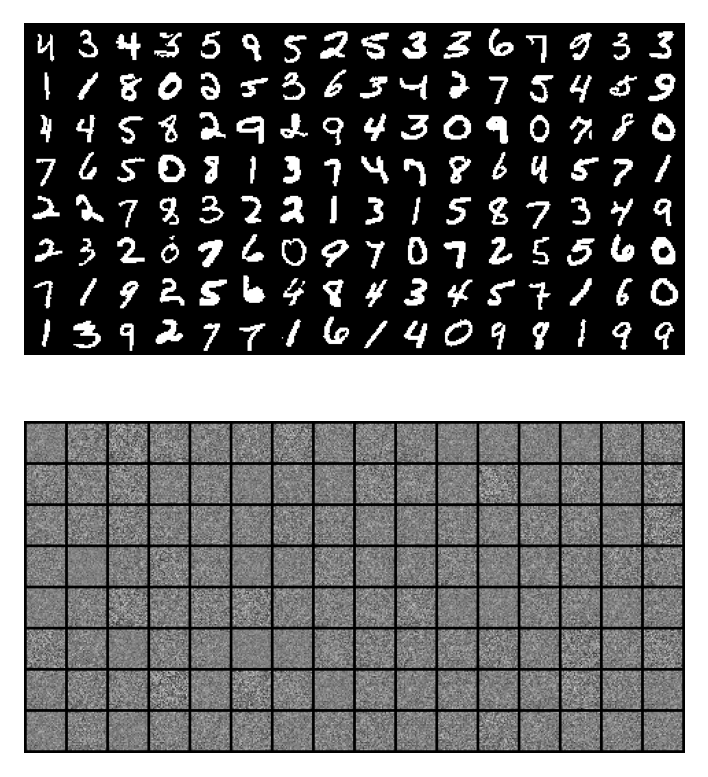

In [149]:
foo = ut.plot_2images(x.reshape(-1,1,28,28), rec.reshape(-1,1,28,28))

In [150]:
vae.cpu()

pyroVAE(
  (encoder): Encoder(
    (Ez): Sequential(
      (linear1): Linear(in_features=784, out_features=512, bias=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): LeakyReLU(negative_slope=0.01)
      (linear2): Linear(in_features=512, out_features=512, bias=True)
      (dropout2): Dropout(p=0.2, inplace=False)
      (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation2): LeakyReLU(negative_slope=0.01)
      (output_layer): Linear(in_features=512, out_features=48, bias=True)
    )
  )
  (decoder): Decoder(
    (Dx): Sequential(
      (linear1): Linear(in_features=24, out_features=512, bias=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): LeakyReLU(negative_slope=0.01)
      (

In [153]:
x,y = train_loader.__iter__().next()
svi.step(x)

72347.6650390625

In [152]:
for x,y in train_loader.__iter__():
    svi.step(x)